In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip install -v python-mecab-ko

Using pip 21.1.3 from /usr/local/lib/python3.7/dist-packages/pip (python 3.7)
Value for scheme.platlib does not match. Please report this to <https://github.com/pypa/pip/issues/9617>
distutils: /usr/local/lib/python3.7/dist-packages
sysconfig: /usr/lib/python3.7/site-packages
Value for scheme.purelib does not match. Please report this to <https://github.com/pypa/pip/issues/9617>
distutils: /usr/local/lib/python3.7/dist-packages
sysconfig: /usr/lib/python3.7/site-packages
Value for scheme.headers does not match. Please report this to <https://github.com/pypa/pip/issues/9617>
distutils: /usr/local/include/python3.7/UNKNOWN
sysconfig: /usr/include/python3.7m/UNKNOWN
Value for scheme.scripts does not match. Please report this to <https://github.com/pypa/pip/issues/9617>
distutils: /usr/local/bin
sysconfig: /usr/bin
Value for scheme.data does not match. Please report this to <https://github.com/pypa/pip/issues/9617>
distutils: /usr/local
sysconfig: /usr
Additional context:
user = False
home

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import re
import urllib.request
import mecab
from tqdm import tqdm
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [16]:
urllib.request.urlretrieve("https://raw.githubusercontent.com/ukairia777/finance_sentiment_corpus/main/finance_data.csv", filename="finance_data.csv")

('finance_data.csv', <http.client.HTTPMessage at 0x7f26c6554890>)

In [17]:
data = pd.read_csv('finance_data.csv')
data['labels'] = data['labels'].replace(['neutral', 'positive', 'negative'],[0, 1, 2])
del data['sentence']

# 중복 제거
data.drop_duplicates(subset=['kor_sentence'], inplace=True)

In [18]:
# 한국어만 남기고 싶으면
data['kor_sentence'] = [re.sub(r'[^ㄱ-ㅎㅏ-ㅣ가-힣 ]',' ',s) for s in data['kor_sentence']]
# 특수용어 삭제
#data['kor_sentence'] = [re.sub('[^A-Za-z0-9가-힣]', ' ', s) for s in data['kor_sentence']]

In [19]:
data.columns = ['label', 'title']

In [20]:
news_labeling = pd.read_csv('/content/drive/MyDrive/경희대/KHUDA/데비_프로젝트/데이터/labeling_news.csv')
news_labeling['title'] = [re.sub(r'[^ㄱ-ㅎㅏ-ㅣ가-힣 ]',' ',s) for s in news_labeling['title']]

In [21]:
data = pd.concat([data,news_labeling])

In [22]:
#인덱스 초기화 -> 0부터 정렬
data = data.reset_index(drop=True)
data

,label,title
0,0,에 따르면 그 회사는 회사가 성장하고 있는 곳이지만 모든 생산을 러시아로...
1,0,테크노폴리스는 컴퓨터 기술과 통신 분야에서 일하는 회사들을 유치하기 위해 만 평...
2,2,국제 전자산업 회사인 엘코텍은 탈린 공장에서 수십 명의 직원을 해고했으며 이전의 ...
3,1,새로운 생산공장으로 인해 회사는 예상되는 수요 증가를 충족시킬 수 있는 능력을 증가...
4,1,년 회사의 업데이트된 전략에 따르면 는 ...
...,...,...
5334,1,주식 초고수는 지금 수혜주 포스코케미칼 에코프로비엠 매수 상위
5335,1,주식 초고수는 지금 믿을 건 실적 뿐 포스코케미칼 에너지솔루션 차전지주...
5336,1,특징주 포스코케미칼 깜짝 실적 힘입어 연일 강세
5337,1,에코프로 포스코 퀘벡서 양극재 대결


In [23]:
import mecab
mecab = mecab.MeCab()
data['tokenized'] = data['title'].apply(mecab.morphs)
data

,label,title,tokenized
0,0,에 따르면 그 회사는 회사가 성장하고 있는 곳이지만 모든 생산을 러시아로...,"[에, 따르, 면, 그, 회사, 는, 회사, 가, 성장, 하, 고, 있, 는, 곳,..."
1,0,테크노폴리스는 컴퓨터 기술과 통신 분야에서 일하는 회사들을 유치하기 위해 만 평...,"[테크노폴리스, 는, 컴퓨터, 기술, 과, 통신, 분야, 에서, 일, 하, 는, 회..."
2,2,국제 전자산업 회사인 엘코텍은 탈린 공장에서 수십 명의 직원을 해고했으며 이전의 ...,"[국제, 전자, 산업, 회사, 인, 엘코, 텍, 은, 탈린, 공장, 에서, 수십, ..."
3,1,새로운 생산공장으로 인해 회사는 예상되는 수요 증가를 충족시킬 수 있는 능력을 증가...,"[새로운, 생산, 공장, 으로, 인해, 회사, 는, 예상, 되, 는, 수요, 증가,..."
4,1,년 회사의 업데이트된 전략에 따르면 는 ...,"[년, 회사, 의, 업데이트, 된, 전략, 에, 따르, 면, 는, 범위, 의, 장기..."
...,...,...,...
5334,1,주식 초고수는 지금 수혜주 포스코케미칼 에코프로비엠 매수 상위,"[주식, 초, 고수, 는, 지금, 수혜, 주, 포스코, 케미, 칼, 에코, 프로, ..."
5335,1,주식 초고수는 지금 믿을 건 실적 뿐 포스코케미칼 에너지솔루션 차전지주...,"[주식, 초, 고수, 는, 지금, 믿, 을, 건, 실적, 뿐, 포스코, 케미, 칼,..."
5336,1,특징주 포스코케미칼 깜짝 실적 힘입어 연일 강세,"[특징, 주, 포스코, 케미, 칼, 깜짝, 실적, 힘입, 어, 연일, 강세]"
5337,1,에코프로 포스코 퀘벡서 양극재 대결,"[에코, 프로, 포스코, 퀘벡, 서, 양극, 재, 대결]"


In [24]:
# 불용어 제거
data['title']=None
stopwords = ['유로','라고','밝혔','대한','명','된다','부터','에게','등','리','관한','드','한다고','몇','코네','던','노','비','았','입니다','할','적','습니다','는다','니','저','로','것','핀란드','만','어','및','다고','고','된','될','약','게','며','지','합니다','아','또','때','겠','뿐','고','있','수','하','기','년','인','되','면','한다','에서','그','했','다','을','의','가','이','은','들','는','좀','잘','걍','과','도','를','으로','자','에','와','한','하다']
for i in range(len(data)):
  stopwords_removed_sentence = [word for word in data.iloc[i,2] if not word in stopwords] # 불용어 제거
  data['title'][i] = stopwords_removed_sentence

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [26]:
del data['tokenized']

In [27]:
senti_df = pd.read_csv('/content/drive/MyDrive/경희대/KHUDA/데비_프로젝트/데이터/senti.csv')
del senti_df['Unnamed: 0']

In [28]:
data = pd.concat([data,senti_df])
data

,label,title
0,0,"[따르, 회사, 회사, 성장, 곳, 지만, 모든, 생산, 러시아, 옮길, 계획, 없]"
1,0,"[테크노폴리스, 컴퓨터, 기술, 통신, 분야, 일, 회사, 유치, 위해, 평방, 미..."
2,2,"[국제, 전자, 산업, 회사, 엘코, 텍, 탈린, 공장, 수십, 직원, 해고, 했으..."
3,1,"[새로운, 생산, 공장, 인해, 회사, 예상, 수요, 증가, 충족, 시킬, 능력, ..."
4,1,"[회사, 업데이트, 전략, 따르, 범위, 장기, 순, 매출, 성장, 목표, 으며, ..."
...,...,...
14806,0,반신반의
14807,1,신비
14808,2,아리송
14809,2,알쏭하


In [30]:
X_data = data['title']
y_data = data['label']

In [31]:
X_train, X_test, y_train, y_test = train_test_split(X_data, y_data, test_size=0.2, random_state=0, stratify=y_data, shuffle=True)

In [34]:
max_features = 3500 #빈도수 상위 ##개 사용
tokenizer = Tokenizer(num_words=max_features)
tokenizer.fit_on_texts(X_train)
X_train_encoded = tokenizer.texts_to_sequences(X_train)
X_test_encoded = tokenizer.texts_to_sequences(X_test)
print(X_train_encoded[:5])
print(X_test_encoded[:5])

[[1185, 564], [359, 565, 298, 994, 1186, 632, 167], [1432, 21], [700, 566], [12]]
[[1688], [1880], [35, 1906], [3415], [3200, 635, 444, 6, 444, 1101, 1043]]


In [ ]:
# vocab_size = 5
# words_frequency = [w for w,c in word_to_index.items() if c >= vocab_size + 1] # 인덱스가 5 초과인 단어 제거
# for w in words_frequency:
#     del word_to_index[w] # 해당 단어에 대한 인덱스 정보를 삭제
# print(word_to_index)

In [35]:
word_to_index = tokenizer.word_index
vocab_size = len(word_to_index) + 1
print(vocab_size) # 단어 개수

10557


In [36]:
word_to_index

{'월': 1,
 '회사': 2,
 '일': 3,
 '었': 4,
 '증가': 5,
 '말': 6,
 '못하': 7,
 '서비스': 8,
 '업체': 9,
 '분기': 10,
 '영업': 11,
 '이익': 12,
 '그룹': 13,
 '시장': 14,
 '않': 15,
 '순': 16,
 '계약': 17,
 '사업': 18,
 '억': 19,
 '예정': 20,
 '마음': 21,
 '매출': 22,
 '까지': 23,
 '없': 24,
 '제공': 25,
 '주': 26,
 '주식': 27,
 '였': 28,
 '총': 29,
 '투자': 30,
 '몹시': 31,
 '기간': 32,
 '제조': 33,
 '발표': 34,
 '맵': 35,
 '좋': 36,
 '포함': 37,
 '공장': 38,
 '개발': 39,
 '제품': 40,
 '모양': 41,
 '생산': 42,
 '위한': 43,
 '인수': 44,
 '데': 45,
 '새로운': 46,
 '감소': 47,
 '자꾸': 48,
 '개': 49,
 '아니하': 50,
 '중': 51,
 '고객': 52,
 '키': 53,
 '사람': 54,
 '삼성전자': 55,
 '솔루션': 56,
 '성': 57,
 '카카오': 58,
 '기술': 59,
 '보': 60,
 '매출액': 61,
 '나': 62,
 '오이': 63,
 '여': 64,
 '직원': 65,
 '기업': 66,
 '사용': 67,
 '기록': 68,
 '같': 69,
 '달러': 70,
 '으며': 71,
 '은행': 72,
 '공급': 73,
 '판매': 74,
 '받': 75,
 '운영': 76,
 '비해': 77,
 '오늘': 78,
 '보다': 79,
 '노키아': 80,
 '예상': 81,
 '이번': 82,
 '우리': 83,
 '산업': 84,
 '건설': 85,
 '거래': 86,
 '순이익': 87,
 '해': 88,
 '지분': 89,
 '라': 90,
 '전': 91,
 '전자': 92,
 '계획': 93,
 '

본문의 최대 길이 : 37
본문의 평균 길이 : 5.913523573200993


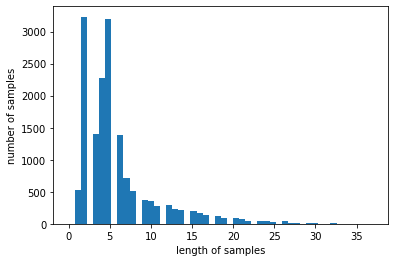

In [37]:
print('본문의 최대 길이 :',max(len(sent) for sent in X_train))
print('본문의 평균 길이 :',sum(map(len, X_train))/len(X_train))
plt.hist([len(sent) for sent in X_train], bins=50)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

In [ ]:
# drop_train = [index for index, sentence in enumerate(X_train) if len(sentence) < 1]
# # 빈 샘플들을 제거
# X_train = np.delete(X_train, drop_train, axis=0)
# y_train = np.delete(y_train, drop_train, axis=0)
# print(len(X_train))
# print(len(y_train))

In [38]:
max_len = 25

In [39]:
X_train_encoded = pad_sequences(X_train_encoded, maxlen=max_len)
X_test_encoded = pad_sequences(X_test_encoded, maxlen=max_len)

In [40]:
X_train_encoded[0]

array([   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0, 1185,  564], dtype=int32)

In [41]:
X_train_encoded.shape

(16120, 25)

In [42]:
X_test_encoded.shape

(4030, 25)

In [43]:
from tensorflow.keras.layers import Embedding, Dense, LSTM
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import load_model
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

In [44]:
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

In [54]:
embedding_dim = 25
hidden_units = 64
num_classes = 3

model = Sequential()
model.add(Embedding(vocab_size, embedding_dim))
model.add(LSTM(hidden_units))
model.add(Dense(num_classes, activation='softmax'))

es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=4)
mc = ModelCheckpoint('best_model4.h5', monitor='val_acc', mode='max', verbose=1, save_best_only=True)

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['acc'])
history = model.fit(X_train_encoded, y_train, 
                    epochs=3, callbacks=[es, mc], batch_size=32, validation_split=0.2)

Epoch 1/3
396/403 [============================>.] - ETA: 0s - loss: 0.7030 - acc: 0.6812
Epoch 1: val_acc improved from -inf to 0.80614, saving model to best_model4.h5
403/403 [==============================] - 4s 6ms/step - loss: 0.6994 - acc: 0.6834 - val_loss: 0.4961 - val_acc: 0.8061
Epoch 2/3
402/403 [============================>.] - ETA: 0s - loss: 0.3857 - acc: 0.8510
Epoch 2: val_acc improved from 0.80614 to 0.83871, saving model to best_model4.h5
403/403 [==============================] - 2s 5ms/step - loss: 0.3857 - acc: 0.8510 - val_loss: 0.4206 - val_acc: 0.8387
Epoch 3/3
397/403 [============================>.] - ETA: 0s - loss: 0.2998 - acc: 0.8823
Epoch 3: val_acc did not improve from 0.83871
403/403 [==============================] - 2s 5ms/step - loss: 0.3003 - acc: 0.8824 - val_loss: 0.4297 - val_acc: 0.8353


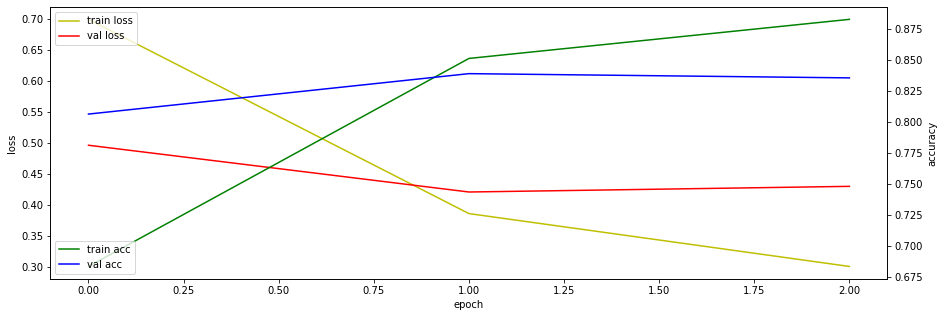

In [55]:
import matplotlib.pyplot as plt

fig, loss_ax = plt.subplots(figsize=(15,5))

acc_ax = loss_ax.twinx()

loss_ax.plot(history.history['loss'], 'y', label='train loss')
loss_ax.plot(history.history['val_loss'], 'r', label='val loss')

acc_ax.plot(history.history['acc'], 'g', label='train acc')
acc_ax.plot(history.history['val_acc'], 'b', label='val acc')

loss_ax.set_xlabel('epoch')
loss_ax.set_ylabel('loss')
acc_ax.set_ylabel('accuracy')

loss_ax.legend(loc='upper left')
acc_ax.legend(loc='lower left')

plt.show()

In [56]:
score = model.evaluate(X_test_encoded, y_test)
print('loss', round(score[0], 2))
print('accuracy', round(score[1], 2))

126/126 [==============================] - 0s 3ms/step - loss: 0.4218 - acc: 0.8390
loss 0.42
accuracy 0.84


In [57]:
loaded_model = load_model('best_model4.h5')

In [58]:
model.save('lstm_model_5.h5')